In [1]:
!pip install torch torchvision torchaudio matplotlib numpy tqdm

In [2]:
# base
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

# helpers
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import v2

In [3]:
plt.style.use('dark_background')

In [4]:
EPOCHS = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
print(f'Epoch: {EPOCHS}')

Device: cpu
Epoch: 5


In [5]:
class DatasetReg (Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')
        
        self.len_dataset = len(self.list_name_file)
        
        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)
        
        img = Image.open(path_img)
        coord = torch.tensor(self.dict_coords[name_file], dtype=torch.float32)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, coord

    def __len__(self):
        return self.len_dataset

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, ), std=(0.5, ))
])

dataset = DatasetReg('./dataset', transform=transform)

In [31]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

In [44]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [45]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, output_size)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        
        return out

model = MyModel(input_size=64*64, output_size=2).to(device)

In [46]:
# input = torch.rand([16, 64*64], dtype=torch.float32).to(device)
# 
# out = model(input)
# out.shape

In [47]:
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [49]:
for epoch in range(EPOCHS):

    # INFO model training
    model.train()
    train_loop = tqdm(train_loader, leave=False)
    
    running_train_loss = []
    true_answer_counter = 0
    for x, targets in train_loop:        
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device) 
        
        prediction = model(x) # forward method
        loss = loss_model(prediction, targets) # loss func
        
        # back prapagetion start
        opt.zero_grad() # reset previously calculated gradients
        loss.backward()
        # back prapagetion end
        
        # optimization step
        opt.step()
        
        # INFO training process visualization
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss_avg: {mean_train_loss:.4f}')

    running_train_acc = true_answer_counter/len(train_set)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # INFO model validation
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer_counter = 0
        for x, targets in val_loader:
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device) 
            
            prediction = model(x)
            loss = loss_model(prediction, targets)
            
            # INFO training process visualization
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
    
        running_val_acc = true_answer_counter / len(val_set)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss: {mean_train_loss:.4f}, train_metric_acc: {running_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}')

Epoch [1/5], train_loss: 1.7854, train_metric_acc: 0.6464, val_loss: 0.3109, val_metric_acc: 0.2432


Epoch [2/5], train_loss: 0.1392, train_metric_acc: 0.6797, val_loss: 0.0903, val_metric_acc: 0.8171


Epoch [3/5], train_loss: 0.1144, train_metric_acc: 0.7487, val_loss: 0.0886, val_metric_acc: 0.8330


Epoch [4/5], train_loss: 0.0988, train_metric_acc: 0.7984, val_loss: 0.2388, val_metric_acc: 0.3745


Epoch [5/5], train_loss: 0.0850, train_metric_acc: 0.8403, val_loss: 0.1348, val_metric_acc: 0.6734


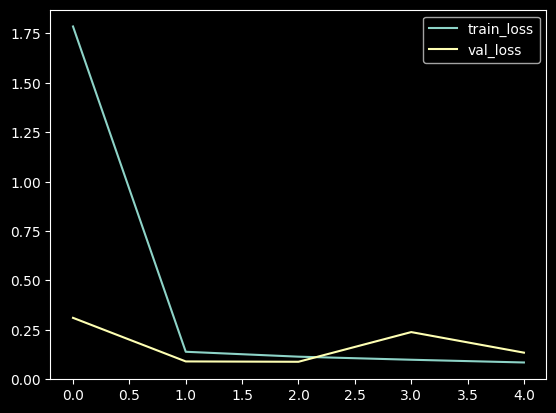

In [52]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

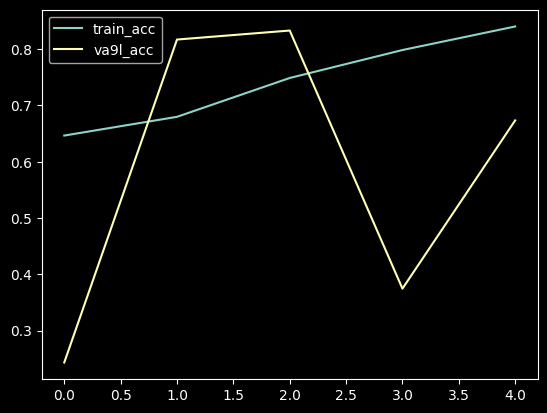

In [53]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'va9l_acc'])
plt.show()